In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Spot The Mask
The objective of this challenge is to create an image classification machine learning model to accurately predict the likelihood that an image contains a person wearing a face mask, or not.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import os

In [3]:
data_dir = "drive/My Drive/Spot_the_mask/images/training/"

In [4]:
os.listdir(data_dir)

['validation', 'train']

In [5]:
train_dir = "drive/My Drive/Spot_the_mask/images/training/train/"
validation_dir = "drive/My Drive/Spot_the_mask/images/training/validation/"

In [6]:
test_path = "drive/My Drive/Spot_the_mask/images/test/"

In [7]:
os.listdir(train_dir)

['mask', 'unmask']

In [8]:
os.listdir(validation_dir)

['mask', 'unmask']

In [9]:
os.listdir(f"{train_dir}/mask")[0]

'coqliuutcrbvczilweljtcvjsonnmr.jpg'

In [10]:
mask = f"{train_dir}/mask/aamrmacbsylkbahdhvcfmeqvgyjopc.jpg"

In [11]:
mask_img = imread(mask)

In [12]:
mask_img

array([[[ 91,  90,  86],
        [ 88,  87,  83],
        [ 83,  82,  78],
        ...,
        [ 37,  37,  35],
        [ 37,  37,  35],
        [ 36,  36,  34]],

       [[108, 109, 104],
        [106, 107, 102],
        [102, 103,  98],
        ...,
        [ 37,  37,  35],
        [ 37,  37,  35],
        [ 36,  36,  34]],

       [[123, 124, 119],
        [121, 122, 117],
        [118, 119, 114],
        ...,
        [ 37,  37,  35],
        [ 36,  36,  34],
        [ 36,  36,  34]],

       ...,

       [[ 11,  13,  12],
        [ 11,  13,  12],
        [ 10,  12,  11],
        ...,
        [ 28,  30,  25],
        [ 28,  31,  24],
        [ 29,  32,  25]],

       [[ 10,  12,  11],
        [ 10,  12,  11],
        [ 10,  12,  11],
        ...,
        [ 28,  30,  25],
        [ 29,  32,  25],
        [ 29,  32,  25]],

       [[ 10,  12,  11],
        [ 10,  12,  11],
        [ 10,  12,  11],
        ...,
        [ 29,  31,  26],
        [ 29,  32,  25],
        [ 30,  33,  26]]

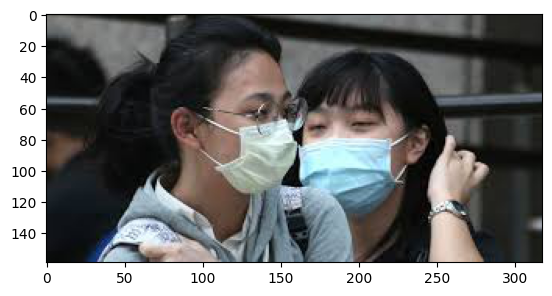

In [13]:
plt.imshow(mask_img)

**Getting the average shape of the test images**

In [14]:
dim1 = []
dim2 = []

for test_image in os.listdir(test_path):
    # reading the image
    image = imread(f"{test_path}/{test_image}")
    d1, d2, _ = image.shape
    dim1.append(d1)
    dim2.append(d2)


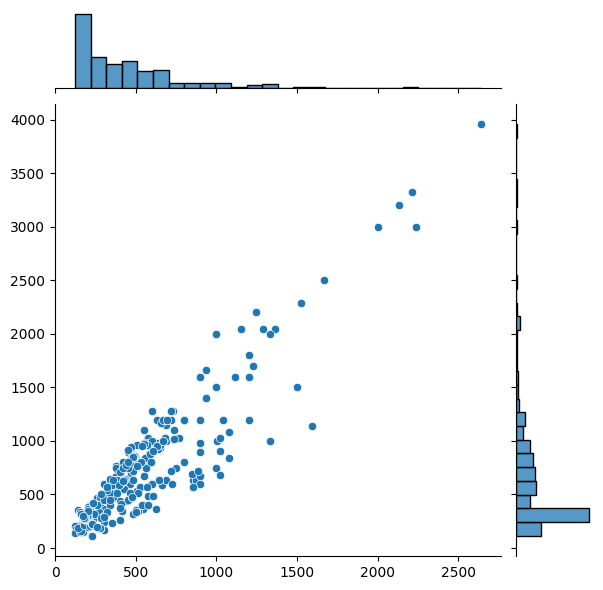

In [15]:
sns.jointplot(x=dim1, y=dim2)

In [16]:
max(dim1), max(dim2)

(2640, 3959)

In [17]:
np.mean(dim1), np.mean(dim2)

(443.66601178781923, 621.3045186640471)

In [19]:
min(dim1), min(dim2)

(122, 115)

In [20]:
image_shape = (180, 180, 3)

## Preparing the data for the model.

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

In [23]:
image_gen.flow_from_directory(train_dir)

Found 1046 images belonging to 2 classes.


In [24]:
image_gen.flow_from_directory(validation_dir)

Found 262 images belonging to 2 classes.


## Creating the Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [45]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3,3),input_shape=image_shape, activation='relu',))

model.add(Flatten())


# model.add(Dense(128))
# model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)     

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [49]:
model_checkpoint = ModelCheckpoint(filepath='drive/My Drive/Spot_the_mask/stm_model.h',
                                   save_best_only = True,
                                   monitor = 'val_loss')

## Training the Model

In [50]:
batch_size = 16

In [51]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 1046 images belonging to 2 classes.


In [52]:
validation_image_gen = image_gen.flow_from_directory(validation_dir,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 262 images belonging to 2 classes.


In [53]:
train_image_gen.class_indices

{'mask': 0, 'unmask': 1}

In [55]:
results = model.fit_generator(train_image_gen,
                              epochs = 50,
                             validation_data=validation_image_gen,
                             callbacks=[early_stop, model_checkpoint])

<ipython-input-55-8d7b48b429f9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_image_gen,


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5277

66/66 [==============================] - 27s 407ms/step - loss: 0.6935 - accuracy: 0.5277 - val_loss: 0.6952 - val_accuracy: 0.4618
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5382

66/66 [==============================] - 26s 403ms/step - loss: 0.6911 - accuracy: 0.5382 - val_loss: 0.6914 - val_accuracy: 0.5305
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5382

66/66 [==============================] - 27s 410ms/step - loss: 0.6868 - accuracy: 0.5382 - val_loss: 0.6912 - val_accuracy: 0.5496
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5889

66/66 [==============================] - 28s 425ms/step - loss: 0.6813 - accuracy: 0.5889 - val_loss: 0.6590 - val_accuracy: 0.6031
Epoch 5/50
66/66 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.6119

66/66 [==============================] - 27s 404ms/step - loss: 0.6539 - accuracy: 0.6119 - val_loss: 0.6302 - val_accuracy: 0.6374
Epoch 6/50
66/66 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.6530

66/66 [==============================] - 26s 404ms/step - loss: 0.6218 - accuracy: 0.6530 - val_loss: 0.6236 - val_accuracy: 0.6679
Epoch 7/50
66/66 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.6654

66/66 [==============================] - 26s 404ms/step - loss: 0.6002 - accuracy: 0.6654 - val_loss: 0.5964 - val_accuracy: 0.6832
Epoch 8/50
66/66 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.6807

66/66 [==============================] - 27s 405ms/step - loss: 0.5858 - accuracy: 0.6807 - val_loss: 0.5440 - val_accuracy: 0.7137
Epoch 9/50
66/66 [==============================] - 29s 441ms/step - loss: 0.5634 - accuracy: 0.7189 - val_loss: 0.5490 - val_accuracy: 0.7405
Epoch 10/50
66/66 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.7447

66/66 [==============================] - 27s 411ms/step - loss: 0.5241 - accuracy: 0.7447 - val_loss: 0.5169 - val_accuracy: 0.7214
Epoch 11/50
66/66 [==============================] - 25s 381ms/step - loss: 0.5292 - accuracy: 0.7409 - val_loss: 0.5614 - val_accuracy: 0.6985
Epoch 12/50
66/66 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7390

66/66 [==============================] - 26s 387ms/step - loss: 0.5238 - accuracy: 0.7390 - val_loss: 0.4998 - val_accuracy: 0.7519
Epoch 13/50
66/66 [==============================] - 25s 378ms/step - loss: 0.4973 - accuracy: 0.7706 - val_loss: 0.5186 - val_accuracy: 0.7595
Epoch 14/50
66/66 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.7658

66/66 [==============================] - 26s 387ms/step - loss: 0.5009 - accuracy: 0.7658 - val_loss: 0.4866 - val_accuracy: 0.7748
Epoch 15/50
66/66 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7553

66/66 [==============================] - 30s 461ms/step - loss: 0.4861 - accuracy: 0.7553 - val_loss: 0.4735 - val_accuracy: 0.7748
Epoch 16/50
66/66 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.7945

66/66 [==============================] - 26s 398ms/step - loss: 0.4608 - accuracy: 0.7945 - val_loss: 0.4653 - val_accuracy: 0.7977
Epoch 17/50
66/66 [==============================] - 25s 382ms/step - loss: 0.4435 - accuracy: 0.7954 - val_loss: 0.5977 - val_accuracy: 0.7214
Epoch 18/50
66/66 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7964

66/66 [==============================] - 31s 463ms/step - loss: 0.4617 - accuracy: 0.7964 - val_loss: 0.4094 - val_accuracy: 0.7863
Epoch 19/50
66/66 [==============================] - 25s 379ms/step - loss: 0.4110 - accuracy: 0.8289 - val_loss: 0.4465 - val_accuracy: 0.7863
Epoch 20/50
66/66 [==============================] - 29s 438ms/step - loss: 0.4013 - accuracy: 0.8098 - val_loss: 0.4425 - val_accuracy: 0.7939
Epoch 21/50
66/66 [==============================] - 25s 379ms/step - loss: 0.4114 - accuracy: 0.8193 - val_loss: 0.4882 - val_accuracy: 0.7634
Epoch 22/50
66/66 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8078

66/66 [==============================] - 26s 393ms/step - loss: 0.4235 - accuracy: 0.8078 - val_loss: 0.3960 - val_accuracy: 0.8244
Epoch 23/50
66/66 [==============================] - 24s 361ms/step - loss: 0.4249 - accuracy: 0.8050 - val_loss: 0.4205 - val_accuracy: 0.8244
Epoch 24/50
66/66 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8470

66/66 [==============================] - 26s 395ms/step - loss: 0.3643 - accuracy: 0.8470 - val_loss: 0.3866 - val_accuracy: 0.8321
Epoch 25/50
66/66 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8222

66/66 [==============================] - 26s 399ms/step - loss: 0.4117 - accuracy: 0.8222 - val_loss: 0.3300 - val_accuracy: 0.8511
Epoch 26/50
66/66 [==============================] - 25s 382ms/step - loss: 0.3460 - accuracy: 0.8614 - val_loss: 0.3972 - val_accuracy: 0.8206
Epoch 27/50
66/66 [==============================] - 25s 381ms/step - loss: 0.3655 - accuracy: 0.8442 - val_loss: 0.3760 - val_accuracy: 0.8359
Epoch 28/50
66/66 [==============================] - 24s 360ms/step - loss: 0.3549 - accuracy: 0.8394 - val_loss: 0.4193 - val_accuracy: 0.8092
Epoch 29/50
66/66 [==============================] - 25s 382ms/step - loss: 0.3339 - accuracy: 0.8576 - val_loss: 0.4431 - val_accuracy: 0.7939
Epoch 30/50
66/66 [==============================] - 29s 442ms/step - loss: 0.3361 - accuracy: 0.8509 - val_loss: 0.4237 - val_accuracy: 0.8092


In [56]:
history_df = pd.DataFrame(model.history.history)

In [57]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693495,0.527725,0.695163,0.461832
1,0.691130,0.538241,0.691415,0.530534
2,0.686816,0.538241,0.691220,0.549618
3,0.681291,0.588910,0.659005,0.603053
4,0.653862,0.611855,0.630155,0.637405


<Axes: >

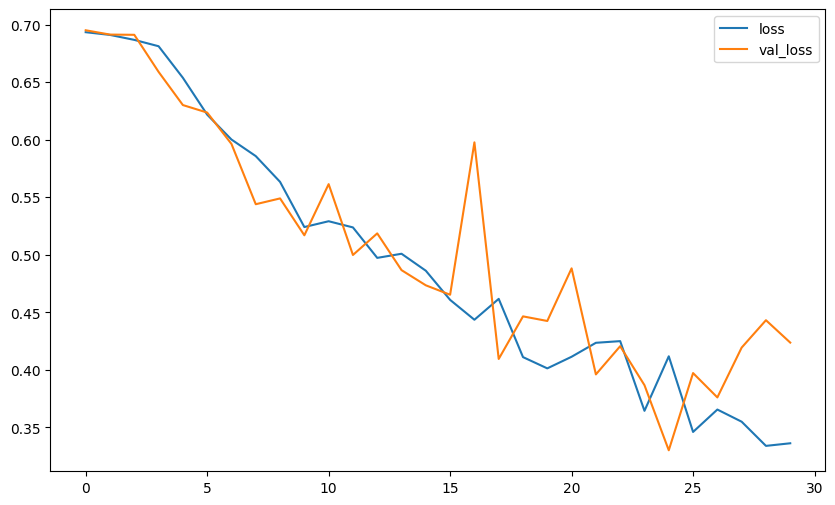

In [58]:
# plotting the losses history
history_df[['loss', 'val_loss']].plot(figsize=(10, 6))

<Axes: >

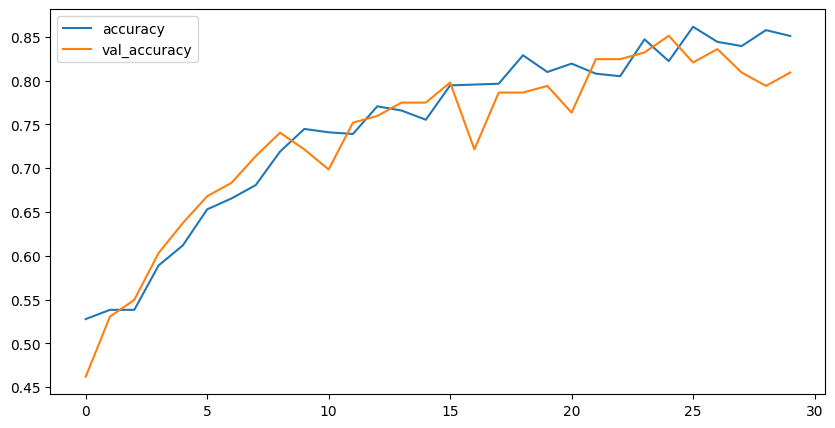

In [59]:
# plotting the accuracy history
history_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 5))

## Load the model

In [60]:
from tensorflow.keras.models import load_model

In [61]:
stm_model = load_model('drive/My Drive/Spot_the_mask/stm_model.h')

In [64]:
stm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)     

In [65]:
val_loss, val_accuracy = stm_model.evaluate(validation_image_gen)

17/17 [==============================] - 7s 296ms/step - loss: 0.3467 - accuracy: 0.8435
